[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kdlamb/SP2-VAE/blob/main/SP2_3DLatentSpace.ipynb)

## SP2 3D Latent Space Analysis
This notebook uses the pyroVED library to analyze signals from the Single Particle Soot Photometer. Here we use a 3D latent space for the scattering and incandescent channels from the NOAA SP2.

## Download the L-II signal data
You can download the NOAA SP2 data directly from the [Zenodo repository](https://zenodo.org/records/15800436) by uncommenting and running the following code (can be slow). Alternatively, you can first download the data directly to your computer and then upload the files to Colab.

In [1]:
#!wget -O Lab_X_train.npy "https://zenodo.org/records/15800436/files/Lab_X_train.npy"
#!wget -O Lab_Y_train.npy "https://zenodo.org/records/15800436/files/Lab_Y_train.npy"
#!wget -O Lab_X_train.npy "https://zenodo.org/records/15800436/files/Lab_X_val.npy"
#!wget -O Lab_Y_train.npy "https://zenodo.org/records/15800436/files/Lab_Y_val.npy"
#!wget -O Lab_X_train.npy "https://zenodo.org/records/15800436/files/Lab_X_test.npy"
#!wget -O Lab_Y_train.npy "https://zenodo.org/records/15800436/files/Lab_Y_test.npy"

## Install packages and load in libraries

In [2]:
!pip install -q git+https://github.com/ziatdinovmax/pyroved.git

In [3]:
import os
import math
import numpy as np
import seaborn as sns
import pandas as pd
import time
import random

import torch

from torch.nn import Conv1d, ConvTranspose1d
from torch.nn import Linear as Lin, ReLU, Sigmoid, ConstantPad1d
from torch.utils.data import Dataset, DataLoader

import pyroved as pv

from matplotlib import pyplot as plt
from tqdm import tqdm

In [4]:
# for reproducibility
np.random.seed(0)
torch.manual_seed(0)

## Preprocess SP2 Data Sets

In [5]:
X_train = np.load("Lab_X_train.npy")
Y_train = np.load("Lab_Y_train.npy")

X_val = np.load("Lab_X_val.npy")
Y_val = np.load("Lab_Y_val.npy")

X_test = np.load("Lab_X_test.npy")
Y_test = np.load("Lab_Y_test.npy")

In [6]:
# APPLY INCANDESCENT THRESHOLD
mask = np.any(X_train[:, :, 1] > 0.2, axis=1)
X_train = X_train[mask]
Y_train = Y_train[mask]

# APPLY INCANDESCENT THRESHOLD
mask_val = np.any(X_val[:, :, 1] > 0.2, axis=1)
X_val = X_val[mask_val]
Y_val = Y_val[mask_val]

# APPLY INCANDESCENT THRESHOLD
mask_test = np.any(X_test[:, :, 1] > 0.2, axis=1)
X_test = X_test[mask_test]
Y_test = Y_test[mask_test]

In [7]:
def get_features(Xdata):
  # proprocess data from the SP2
  # get typical features used in analysis (color ratio, peak heights)
  # normalize data for each channel

  X_min = np.min(Xdata,axis=1)
  X_max = np.max(Xdata,axis=1)
  # Calculate the color ratio
  color_ratio = X_max[:,1] / X_max[:,2]

  X_norm = (Xdata-np.repeat(X_min[:,np.newaxis,:],400,axis=1))
  X_norm/=(np.repeat(X_max[:,np.newaxis,:],400,axis=1)-np.repeat(X_min[:,np.newaxis,:],400,axis=1))

  return X_norm,color_ratio,X_min,X_max

In [8]:
X_train,color_channel_ratio,channel_min_X_train,channel_max_X_train = get_features(X_train)
X_val,color_channel_ratio_val,channel_min_X_val,channel_max_X_val = get_features(X_val)
X_test,color_channel_ratio_test,channel_min_test,channel_max_X_test = get_features(X_test)


Text(0.5, 1.0, 'Ch. 3')

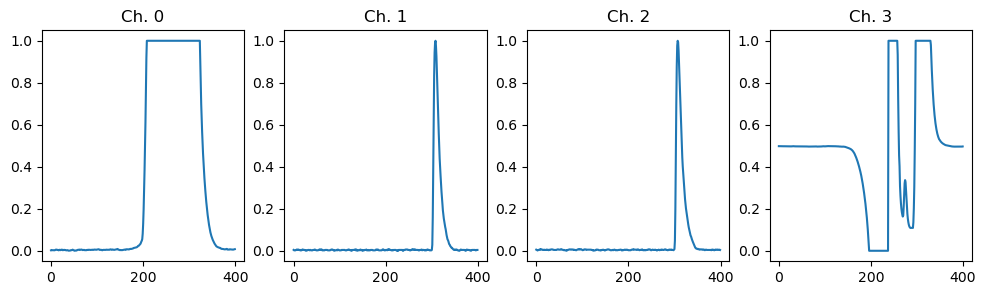

In [9]:
n = random.randint(1, X_train.shape[0])
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12,3))
axes[0].plot(X_train[n,:,0])
axes[0].set_title("Ch. 0")
axes[1].plot(X_train[n,:,1])
axes[1].set_title("Ch. 1")
axes[2].plot(X_train[n,:,2])
axes[2].set_title("Ch. 2")
axes[3].plot(X_train[n,:,3])
axes[3].set_title("Ch. 3")


## Train VAE models on Ch. 0 and Ch. 1

In [10]:
X_train_C0 = torch.from_numpy(X_train[:,:, 0]).float()
train_loader_0 = pv.utils.init_dataloader(X_train_C0.unsqueeze(1), batch_size=64)

X_train_C1 = torch.from_numpy(X_train[:,:, 1]).float()
train_loader_1 = pv.utils.init_dataloader(X_train_C1.unsqueeze(1), batch_size=64)

X_val_C0 = torch.from_numpy(X_val[:,:, 0]).float()
val_loader_0 = pv.utils.init_dataloader(X_val_C0.unsqueeze(1), batch_size=64)

X_val_C1 = torch.from_numpy(X_val[:,:, 1]).float()
val_loader_1 = pv.utils.init_dataloader(X_val_C1.unsqueeze(1), batch_size=64)

X_test_C0 = torch.from_numpy(X_test[:,:, 0]).float()
test_loader_0 = pv.utils.init_dataloader(X_test_C0.unsqueeze(1), batch_size=64)

X_test_C1 = torch.from_numpy(X_test[:,:, 1]).float()
test_loader_1 = pv.utils.init_dataloader(X_test_C1.unsqueeze(1), batch_size=64)

In [11]:
# Initialize vanilla VAE
vae0 = pv.models.iVAE(data_dim = (400,), latent_dim = 3, invariances=None, sampler_d = 'gaussian', seed=0)

# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(vae0)

In [12]:
# Train for n epochs:
for e in range(200):
    trainer.step(train_loader_0)
    trainer.print_statistics()
torch.save(vae0.state_dict(), "3DVAE_Ch0_200.pth")

Epoch: 1 Training loss: 105.0903
Epoch: 2 Training loss: 100.2811
Epoch: 3 Training loss: 99.6954
Epoch: 4 Training loss: 99.4088
Epoch: 5 Training loss: 99.1931
Epoch: 6 Training loss: 99.0604
Epoch: 7 Training loss: 98.9697
Epoch: 8 Training loss: 98.8840
Epoch: 9 Training loss: 98.8211
Epoch: 10 Training loss: 98.7538
Epoch: 11 Training loss: 98.7335
Epoch: 12 Training loss: 98.7015
Epoch: 13 Training loss: 98.6574
Epoch: 14 Training loss: 98.6353
Epoch: 15 Training loss: 98.5973
Epoch: 16 Training loss: 98.5862
Epoch: 17 Training loss: 98.5866
Epoch: 18 Training loss: 98.5611
Epoch: 19 Training loss: 98.5463
Epoch: 20 Training loss: 98.5283
Epoch: 21 Training loss: 98.5215
Epoch: 22 Training loss: 98.4949
Epoch: 23 Training loss: 98.5018
Epoch: 24 Training loss: 98.5033
Epoch: 25 Training loss: 98.4935
Epoch: 26 Training loss: 98.4687
Epoch: 27 Training loss: 98.4910
Epoch: 28 Training loss: 98.4364
Epoch: 29 Training loss: 98.4511
Epoch: 30 Training loss: 98.4556
Epoch: 31 Trainin

In [12]:
# Load in the trained model weights
vae0.load_state_dict(torch.load('3DVAE_Ch0_200.pth',weights_only=True))

<All keys matched successfully>

In [13]:
vae1 = pv.models.iVAE(data_dim = (400,), latent_dim = 3, invariances=None, sampler_d = 'gaussian', seed=0)

# Initialize SVI trainer
trainer1 = pv.trainers.SVItrainer(vae1)

In [16]:
# Train for n epochs:
for e in range(200):
    trainer1.step(train_loader_1)
    trainer1.print_statistics()
torch.save(vae1.state_dict(), "3DVAE_Ch1_200.pth")

Epoch: 1 Training loss: 102.2765
Epoch: 2 Training loss: 97.4423
Epoch: 3 Training loss: 97.0049
Epoch: 4 Training loss: 96.7832
Epoch: 5 Training loss: 96.6409
Epoch: 6 Training loss: 96.5493
Epoch: 7 Training loss: 96.4871
Epoch: 8 Training loss: 96.4342
Epoch: 9 Training loss: 96.4008
Epoch: 10 Training loss: 96.3647
Epoch: 11 Training loss: 96.3495
Epoch: 12 Training loss: 96.3225
Epoch: 13 Training loss: 96.3032
Epoch: 14 Training loss: 96.2938
Epoch: 15 Training loss: 96.2763
Epoch: 16 Training loss: 96.2708
Epoch: 17 Training loss: 96.2597
Epoch: 18 Training loss: 96.2405
Epoch: 19 Training loss: 96.2386
Epoch: 20 Training loss: 96.2183
Epoch: 21 Training loss: 96.2232
Epoch: 22 Training loss: 96.2017
Epoch: 23 Training loss: 96.1904
Epoch: 24 Training loss: 96.1795
Epoch: 25 Training loss: 96.1638
Epoch: 26 Training loss: 96.1677
Epoch: 27 Training loss: 96.1592
Epoch: 28 Training loss: 96.1398
Epoch: 29 Training loss: 96.1485
Epoch: 30 Training loss: 96.1318
Epoch: 31 Training

In [14]:
# Load in the trained model weights
vae1.load_state_dict(torch.load('3DVAE_Ch1_200.pth',weights_only=True))

<All keys matched successfully>

In [15]:
# Encode each sample as latent variables
z_mean_0, z_sd_0 = vae0.encode(X_train_C0)
z_mean_1, z_sd_1 = vae1.encode(X_train_C1)

zval_mean_0, zval_sd_0 = vae0.encode(X_val_C0)
zval_mean_1, zval_sd_1 = vae1.encode(X_val_C1)

ztest_mean_0, ztest_sd_0 = vae0.encode(X_test_C0)
ztest_mean_1, ztest_sd_1 = vae1.encode(X_test_C1)

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from matplotlib.colors import ListedColormap

target_names = ["FS", "FS+glyc", "CFA", "ATD", "VA", "$Fe_{2}O_{3}$", "$Fe_{3}O_{4}$"]
cmap1 = ListedColormap(['red', 'purple', 'orange', 'gray', 'brown', 'blue', 'green'])

In [98]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (needed for 3D)
import matplotlib.pyplot as plt
import numpy as np

def set_equal_aspect_3d(ax, x, y, z):
    # Make 3D aspect roughly equal
    xyz_min = np.array([x.min(), y.min(), z.min()])
    xyz_max = np.array([x.max(), y.max(), z.max()])
    ranges = xyz_max - xyz_min
    max_range = ranges.max()
    mid = (xyz_max + xyz_min) / 2.0
    ax.set_xlim(mid[0] - max_range/2, mid[0] + max_range/2)
    ax.set_ylim(mid[1] - max_range/2, mid[1] + max_range/2)
    ax.set_zlim(mid[2] - max_range/2, mid[2] + max_range/2)
    ax.set_box_aspect([1,1,1])

def plot_latent_3d(z_mean_0,z_mean_1, Y_train_filtered, target_names, cmap1, fname='latent3d.png'):
    """
    z_mean: (N, D) latent array with D >= 3
    Y_train_filtered: (N,) class labels in {0..6}
    target_names: list of 7 class names
    cmap1: callable colormap taking idx -> color
    """
    fig = plt.figure(figsize=(20, 20))
    gs = fig.add_gridspec(4, 4, wspace=0.15, hspace=0.25)

    # Per-class panels (7) + one "All Classes"
    axes = []
    for k in range(7):
        ax = fig.add_subplot(gs[k//4, k%4], projection='3d')
        axes.append(ax)

    ax_all = fig.add_subplot(gs[1, 3], projection='3d')

    # Plot per class
    for idx_0 in range(7):
        class_indices = np.where(Y_train_filtered == idx_0)[0]
        if class_indices.size == 0:
            continue
        zc = z_mean_0[class_indices, :3]
        ax = axes[idx_0]
        ax.scatter(zc[:, 0], zc[:, 1], zc[:, 2], s=2, alpha=0.8,
                   color=cmap1(idx_0), label=target_names[idx_0])
        ax.set_title(target_names[idx_0], fontsize=16)
        ax.set_xlabel(r"$z_1$", fontsize=14, labelpad=6)
        ax.set_ylabel(r"$z_2$", fontsize=14, labelpad=6)
        ax.set_zlabel(r"$z_3$", fontsize=14, labelpad=6)
        ax.tick_params(axis='both', which='major', labelsize=11)
        # Equal-ish aspect for each panel
        set_equal_aspect_3d(ax, zc[:, 0], zc[:, 1], zc[:, 2])

    # Combined panel
    for idx_0 in range(7):
        class_indices = np.where(Y_train_filtered == idx_0)[0]
        if class_indices.size == 0:
            continue
        zc = z_mean_0[class_indices, :3]
        ax_all.scatter(zc[:, 0], zc[:, 1], zc[:, 2], s=2, alpha=0.8,
                       color=cmap1(idx_0), label=target_names[idx_0])

    ax_all.set_title("All Classes", fontsize=16)
    ax_all.set_xlabel(r"$z_1$", fontsize=14, labelpad=6)
    ax_all.set_ylabel(r"$z_2$", fontsize=14, labelpad=6)
    ax_all.set_zlabel(r"$z_3$", fontsize=14, labelpad=6)
    ax_all.tick_params(axis='both', which='major', labelsize=11)
    # Equal-ish aspect for combined
    # Compute from all points to avoid distortions
    z_all = z_mean_0[:, :3]
    set_equal_aspect_3d(ax_all, z_all[:, 0], z_all[:, 1], z_all[:, 2])
    # Put legend only on the combined panel
    ax_all.legend(fontsize=11, loc='upper left', bbox_to_anchor=(1.02, 1.0))

    axes2 = []
    for k in range(7):
        ax = fig.add_subplot(gs[k//4+2, k%4], projection='3d')
        axes2.append(ax)

    ax_all2 = fig.add_subplot(gs[3, 3], projection='3d')
        # Plot per class
    for idx_0 in range(7):
        class_indices = np.where(Y_train_filtered == idx_0)[0]
        if class_indices.size == 0:
            continue
        zc = z_mean_1[class_indices, :3]
        ax = axes2[idx_0]
        ax.scatter(zc[:, 0], zc[:, 1], zc[:, 2], s=2, alpha=0.8,
                   color=cmap1(idx_0), label=target_names[idx_0])
        ax.set_title(target_names[idx_0], fontsize=16)
        ax.set_xlabel(r"$z_1$", fontsize=14, labelpad=6)
        ax.set_ylabel(r"$z_2$", fontsize=14, labelpad=6)
        ax.set_zlabel(r"$z_3$", fontsize=14, labelpad=6)
        ax.tick_params(axis='both', which='major', labelsize=11)
        # Equal-ish aspect for each panel
        set_equal_aspect_3d(ax, zc[:, 0], zc[:, 1], zc[:, 2])

    # Combined panel
    for idx_0 in range(7):
        class_indices = np.where(Y_train_filtered == idx_0)[0]
        if class_indices.size == 0:
            continue
        zc = z_mean_1[class_indices, :3]
        ax_all2.scatter(zc[:, 0], zc[:, 1], zc[:, 2], s=2, alpha=0.8,
                       color=cmap1(idx_0), label=target_names[idx_0])

    ax_all2.set_title("All Classes", fontsize=16)
    ax_all2.set_xlabel(r"$z_1$", fontsize=14, labelpad=6)
    ax_all2.set_ylabel(r"$z_2$", fontsize=14, labelpad=6)
    ax_all2.set_zlabel(r"$z_3$", fontsize=14, labelpad=6)
    ax_all2.tick_params(axis='both', which='major', labelsize=11)
    # Equal-ish aspect for combined
    # Compute from all points to avoid distortions
    z_all2 = z_mean_1[:, :3]
    set_equal_aspect_3d(ax_all2, z_all2[:, 0], z_all2[:, 1], z_all2[:, 2])
    # Put legend only on the combined panel
    ax_all2.legend(fontsize=11, loc='upper left', bbox_to_anchor=(1.02, 1.0))

    
    for ax in axes:
        ax.set_xlim(-5, 5)
        ax.set_ylim(-5, 5)
        ax.set_zlim(-5, 5)
    ax_all.set_xlim(-5,5)
    ax_all.set_ylim(-5,5)
    ax_all.set_zlim(-5,5)
    for ax in axes2:
        ax.set_xlim(-5, 5)
        ax.set_ylim(-5, 5)
        ax.set_zlim(-5, 5)
    ax_all2.set_xlim(-5,5)
    ax_all2.set_ylim(-5,5)
    ax_all2.set_zlim(-5,5)

    plt.tight_layout()
    plt.savefig(fname, dpi=300, bbox_inches='tight')
    #plt.show()

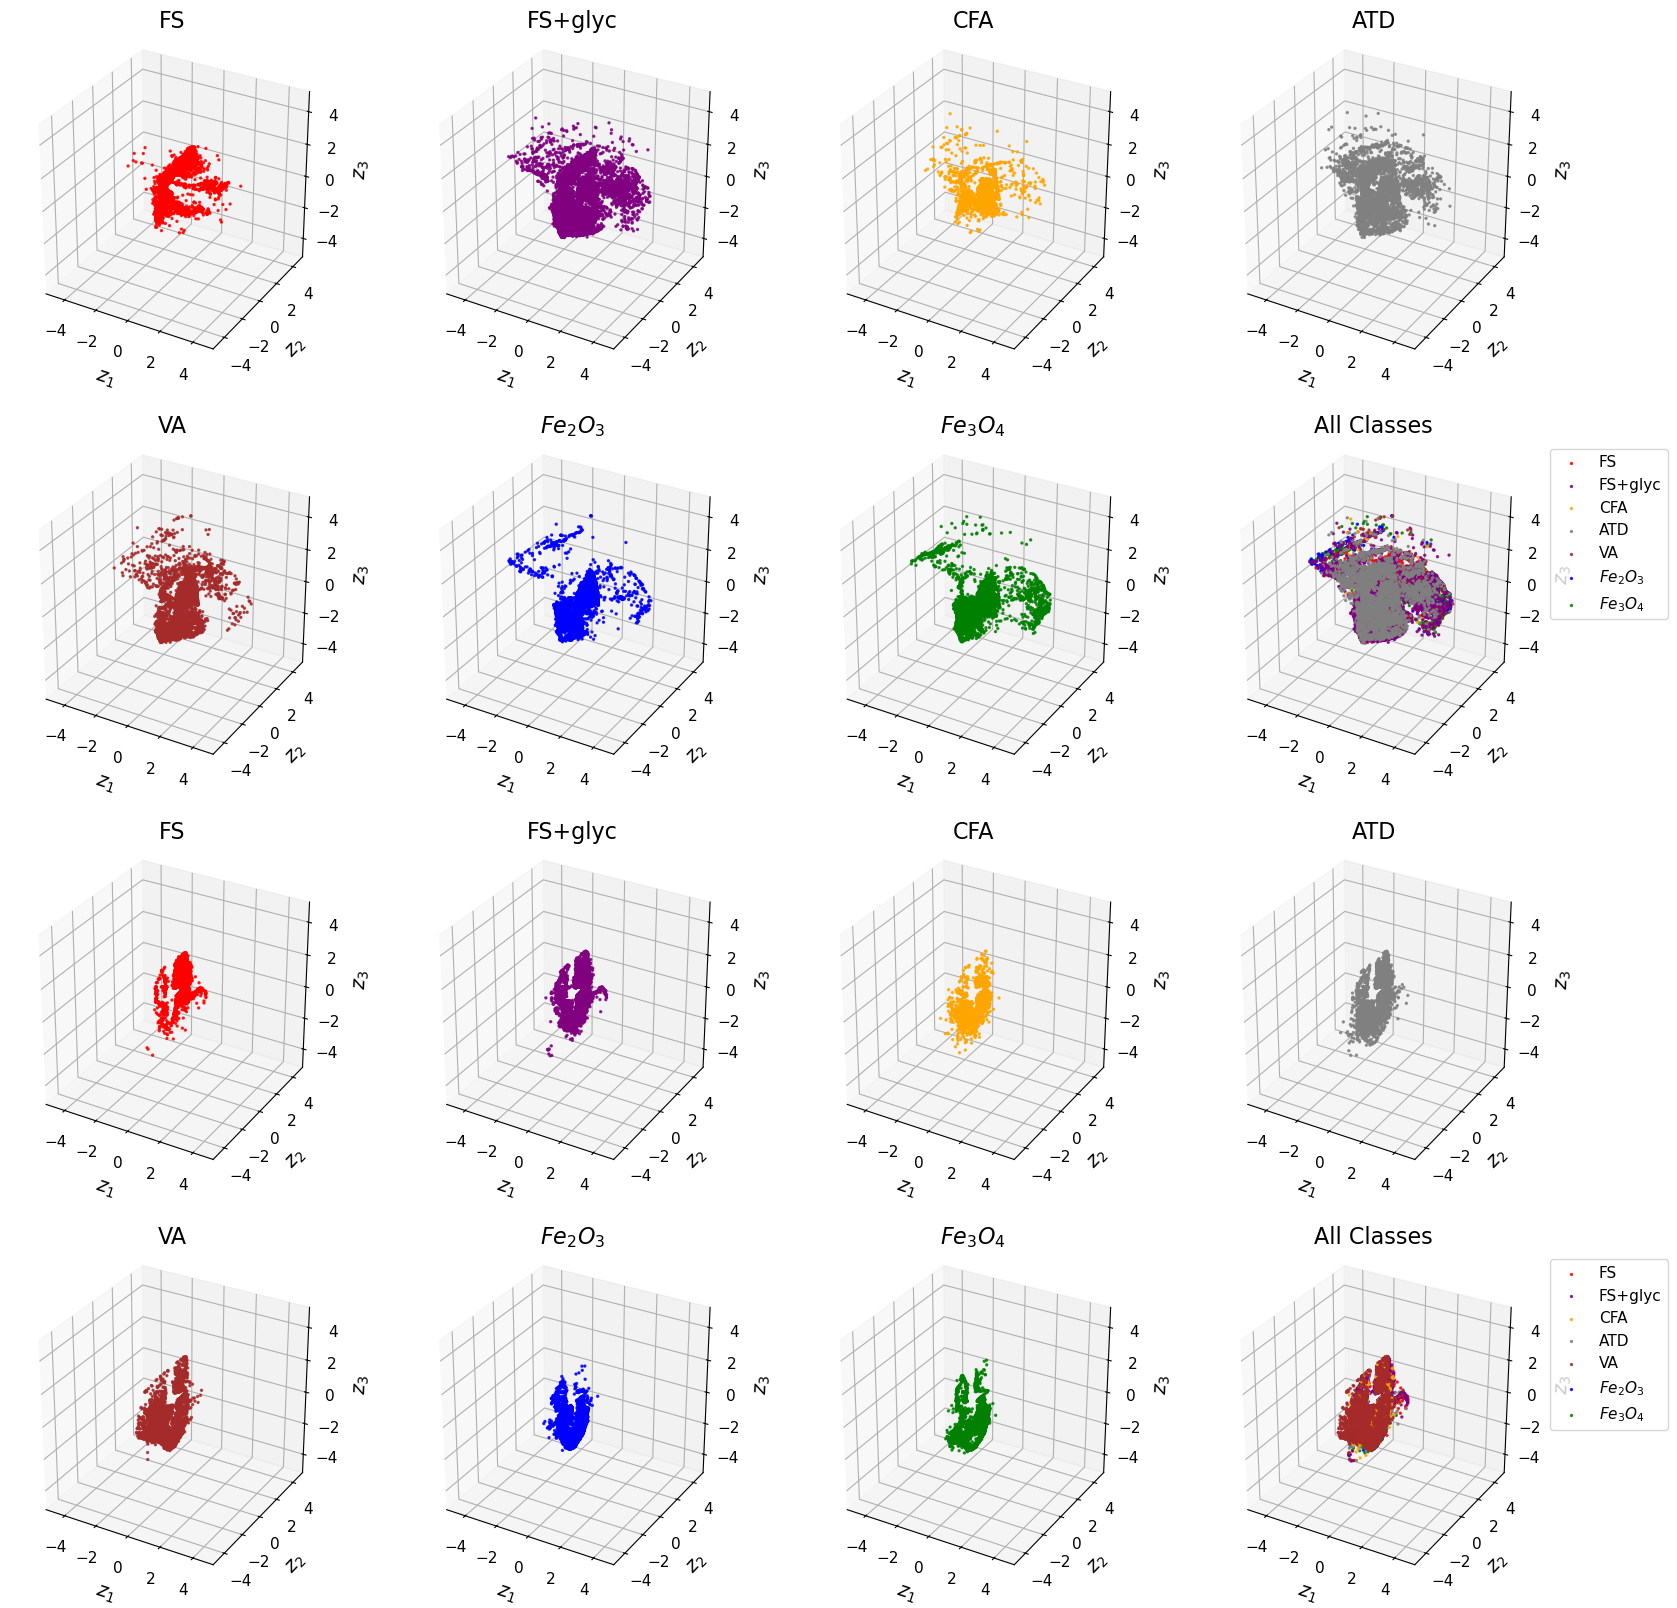

In [99]:
plot_latent_3d(z_mean_0,z_mean_1, Y_train, target_names, cmap1, fname='LatentSpacebyClass_3DVAE.png')

## Calculate Cosine Similarity Metric

In [19]:
from sklearn.metrics.pairwise import cosine_similarity

In [20]:
z_all = np.hstack((z_mean_0,z_mean_1))
zval_all = np.hstack((zval_mean_0,zval_mean_1))
ztest_all = np.hstack((ztest_mean_0,ztest_mean_1))
print(z_all.shape)

(85832, 6)


In [21]:
def calculate_cos_sim(embeddings,class_labels):
  n_classes = len(np.unique(class_labels))

  class_cos_sims = np.zeros((n_classes,n_classes))
  for i in range(0,n_classes):
      for j in range(0,n_classes):
          classA_indices = np.where(class_labels == i)
          classB_indices = np.where(class_labels == j)
          pc_classA = embeddings[classA_indices[0],:]
          pc_classB = embeddings[classB_indices[0],:]
          pairwise_similarities = cosine_similarity(pc_classA,pc_classB)
          class_cos_sims[i,j] = np.mean(pairwise_similarities)
  return class_cos_sims

In [22]:
cos_sims_Ch0 = calculate_cos_sim(z_mean_0,Y_train)
cos_sims_Ch1 = calculate_cos_sim(z_mean_1,Y_train)

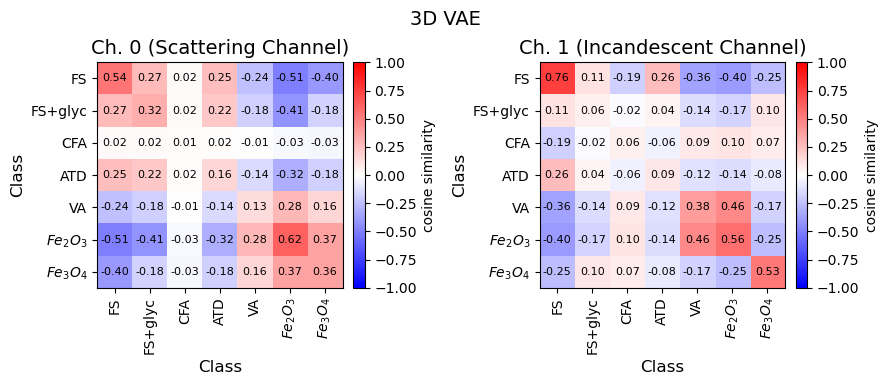

In [102]:
fig, axs = plt.subplots(1,2,figsize=(9, 4))
cos_sims = [cos_sims_Ch0,cos_sims_Ch1]
names = ["Ch. 0 (Scattering Channel)","Ch. 1 (Incandescent Channel)"]

fig.suptitle("3D VAE", fontsize=14,y=0.95)
for k in range(0,2):
    ax = axs[k]
    im = ax.imshow(cos_sims[k], aspect='auto', origin='upper',vmin=-1,vmax=1,cmap="bwr")
    ax.set_title(names[k], fontsize=14)
    ax.set_xlabel('Class', fontsize=12)
    ax.set_ylabel('Class', fontsize=12)

    ax.set_xticks(range(len(target_names)))
    ax.set_xticklabels(target_names, rotation=90)
    ax.set_yticks(range(len(target_names)))
    ax.set_yticklabels(target_names)
    # Colorbar
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=10)
    cbar.set_label("cosine similarity")

    for i in range(cos_sims[k].shape[0]):
        for j in range(cos_sims[k].shape[0]):
            val = cos_sims[k][i, j]
            text = "{:.2f}".format(val)
            ax.text(j, i, text, ha='center', va='center', fontsize=8)
plt.tight_layout()
plt.savefig("CosineSimilarity_3DVAE.png",dpi=300)

## Random Forest Analysis with 3D latent space

In [24]:
# get rid of outliers
color_channel_ratio[color_channel_ratio>2] = 1
color_channel_ratio_val[color_channel_ratio_val>2] = 1
color_channel_ratio_test[color_channel_ratio_test>2] = 1
count = np.sum(color_channel_ratio > 2)
count

0

In [25]:
z_all = np.hstack((z_mean_0,z_mean_1))
z_all = np.hstack((z_all,color_channel_ratio.reshape(-1, 1),channel_max_X_train[:,0:2]))

zval_all = np.hstack((zval_mean_0,zval_mean_1))
zval_all = np.hstack((zval_all,color_channel_ratio_val.reshape(-1, 1),channel_max_X_val[:,0:2]))

ztest_all = np.hstack((ztest_mean_0,ztest_mean_1))
ztest_all = np.hstack((ztest_all,color_channel_ratio_test.reshape(-1, 1),channel_max_X_test[:,0:2]))

In [26]:
from sklearn.preprocessing import StandardScaler, normalize

In [27]:
scaler = StandardScaler()
x_all = scaler.fit_transform(z_all)
xval_all = scaler.transform(zval_all)
xtest_all = scaler.transform(ztest_all)

In [28]:
pd.DataFrame(x_all).describe()

,0,1,2,3,4,5,6,7,8
count,85832.000000,8.583200e+04,8.583200e+04,8.583200e+04,8.583200e+04,8.583200e+04,8.583200e+04,8.583200e+04,8.583200e+04
mean,0.000000,1.721886e-17,-1.059622e-17,8.476976e-17,3.708677e-17,3.178866e-17,1.258301e-14,-2.435541e-14,1.650361e-15
std,1.000006,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00
min,-6.752929,-2.071746e+00,-2.302515e+00,-2.710863e+00,-4.290933e+00,-2.183144e+00,-4.556394e+00,-1.629941e+00,-7.678647e-01
25%,-0.253681,-7.977485e-01,-8.168731e-01,-6.938198e-01,-8.041515e-01,-7.196449e-01,-8.821375e-01,-1.272180e+00,-6.957786e-01
50%,-0.147182,1.195524e-02,-1.820321e-01,1.818601e-02,2.743548e-01,-8.303380e-03,-2.179800e-02,7.039501e-01,-3.768585e-01
75%,0.054935,7.024919e-01,9.519170e-01,6.613024e-01,8.456452e-01,8.193555e-01,7.918858e-01,7.236437e-01,3.023881e-01
max,6.676402,3.151609e+00,4.066793e+00,4.905491e+00,3.201264e+00,2.881204e+00,7.166129e+00,1.074370e+00,3.988303e+00


In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

rf = RandomForestClassifier()
rf.fit(x_all, Y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [30]:
y_output = rf.predict(xval_all)

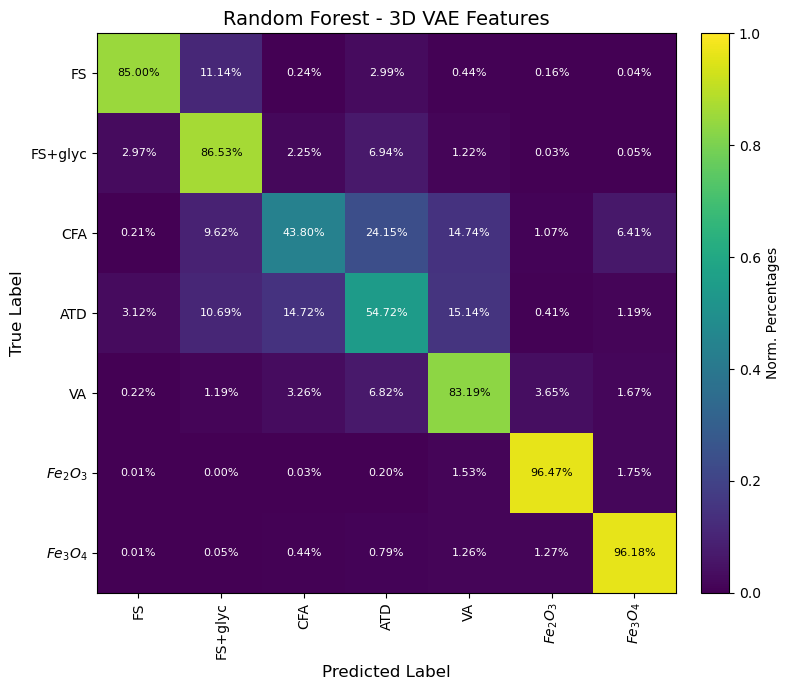

In [100]:
fig, ax = plt.subplots(figsize=(8, 7))

correlation_arr = confusion_matrix(y_output, Y_val, normalize='true')

im = ax.imshow(correlation_arr, aspect='auto', origin='upper',vmin=0,vmax=1,cmap="viridis")
ax.set_title("Random Forest - 3D VAE Features", fontsize=14)
ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)

ax.set_xticks(range(len(target_names)))
ax.set_xticklabels(target_names, rotation=90)
ax.set_yticks(range(len(target_names)))
ax.set_yticklabels(target_names)
# Colorbar
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=10)
cbar.set_label("Norm. Percentages")

for i in range(correlation_arr.shape[0]):
    for j in range(correlation_arr.shape[0]):
        val = correlation_arr[i, j]
        text = "{:.2%}".format(val)
        if val>0.75:
          ax.text(j, i, text, ha='center', va='center', fontsize=8,color='black')
        else:
          ax.text(j, i, text, ha='center', va='center', fontsize=8,color='white')
plt.tight_layout()
plt.savefig('confusion_matrix_3DVAE.png', dpi=300)

## Intrinsic Dimensionality of L-II Signals

In [41]:
# Load in the 2D weights
vae02 = pv.models.iVAE(data_dim = (400,), latent_dim = 2, invariances=None, sampler_d = 'gaussian', seed=0)
vae02.load_state_dict(torch.load('2DVAE_Ch0_200.pth',weights_only=True))
vae12 = pv.models.iVAE(data_dim = (400,), latent_dim = 2, invariances=None, sampler_d = 'gaussian', seed=0)
vae12.load_state_dict(torch.load('2DVAE_Ch1_200.pth',weights_only=True))

<All keys matched successfully>

In [32]:
# Train 4D VAE
vae04 = pv.models.iVAE(data_dim = (400,), latent_dim = 4, invariances=None, sampler_d = 'gaussian', seed=0)

# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(vae04)

In [33]:
# Train for n epochs:
for e in range(200):
    trainer.step(train_loader_0)
    trainer.print_statistics()
torch.save(vae04.state_dict(), "4DVAE_Ch0_200.pth")

Epoch: 1 Training loss: 105.4394
Epoch: 2 Training loss: 100.3009
Epoch: 3 Training loss: 99.7301
Epoch: 4 Training loss: 99.3982
Epoch: 5 Training loss: 99.2330
Epoch: 6 Training loss: 99.0658
Epoch: 7 Training loss: 98.9569
Epoch: 8 Training loss: 98.8919
Epoch: 9 Training loss: 98.8279
Epoch: 10 Training loss: 98.7668
Epoch: 11 Training loss: 98.7156
Epoch: 12 Training loss: 98.6936
Epoch: 13 Training loss: 98.6812
Epoch: 14 Training loss: 98.6465
Epoch: 15 Training loss: 98.6250
Epoch: 16 Training loss: 98.6045
Epoch: 17 Training loss: 98.5984
Epoch: 18 Training loss: 98.5836
Epoch: 19 Training loss: 98.5581
Epoch: 20 Training loss: 98.5493
Epoch: 21 Training loss: 98.5347
Epoch: 22 Training loss: 98.5386
Epoch: 23 Training loss: 98.5251
Epoch: 24 Training loss: 98.5043
Epoch: 25 Training loss: 98.4980
Epoch: 26 Training loss: 98.4890
Epoch: 27 Training loss: 98.4898
Epoch: 28 Training loss: 98.4798
Epoch: 29 Training loss: 98.4734
Epoch: 30 Training loss: 98.4503
Epoch: 31 Trainin

In [34]:
vae14 = pv.models.iVAE(data_dim = (400,), latent_dim = 4, invariances=None, sampler_d = 'gaussian', seed=0)

# Initialize SVI trainer
trainer1 = pv.trainers.SVItrainer(vae14)

In [35]:
# Train for n epochs:
for e in range(200):
    trainer1.step(train_loader_1)
    trainer1.print_statistics()
torch.save(vae14.state_dict(), "4DVAE_Ch1_200.pth")

Epoch: 1 Training loss: 102.8523
Epoch: 2 Training loss: 97.5105
Epoch: 3 Training loss: 97.0459
Epoch: 4 Training loss: 96.7848
Epoch: 5 Training loss: 96.6441
Epoch: 6 Training loss: 96.5429
Epoch: 7 Training loss: 96.4857
Epoch: 8 Training loss: 96.4376
Epoch: 9 Training loss: 96.4069
Epoch: 10 Training loss: 96.3889
Epoch: 11 Training loss: 96.3496
Epoch: 12 Training loss: 96.3358
Epoch: 13 Training loss: 96.3199
Epoch: 14 Training loss: 96.3007
Epoch: 15 Training loss: 96.2855
Epoch: 16 Training loss: 96.2710
Epoch: 17 Training loss: 96.2663
Epoch: 18 Training loss: 96.2440
Epoch: 19 Training loss: 96.2425
Epoch: 20 Training loss: 96.2333
Epoch: 21 Training loss: 96.2183
Epoch: 22 Training loss: 96.2166
Epoch: 23 Training loss: 96.2052
Epoch: 24 Training loss: 96.1970
Epoch: 25 Training loss: 96.1884
Epoch: 26 Training loss: 96.1774
Epoch: 27 Training loss: 96.1677
Epoch: 28 Training loss: 96.1805
Epoch: 29 Training loss: 96.1628
Epoch: 30 Training loss: 96.1633
Epoch: 31 Training

In [36]:
# Train 5D VAE
vae05 = pv.models.iVAE(data_dim = (400,), latent_dim = 5, invariances=None, sampler_d = 'gaussian', seed=0)

# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(vae05)

In [37]:
# Train for n epochs:
for e in range(200):
    trainer.step(train_loader_0)
    trainer.print_statistics()
torch.save(vae05.state_dict(), "5DVAE_Ch0_200.pth")

Epoch: 1 Training loss: 105.4416
Epoch: 2 Training loss: 100.4364
Epoch: 3 Training loss: 99.9279
Epoch: 4 Training loss: 99.6069
Epoch: 5 Training loss: 99.4060
Epoch: 6 Training loss: 99.2586
Epoch: 7 Training loss: 99.1267
Epoch: 8 Training loss: 99.0387
Epoch: 9 Training loss: 98.9372
Epoch: 10 Training loss: 98.8862
Epoch: 11 Training loss: 98.8198
Epoch: 12 Training loss: 98.7844
Epoch: 13 Training loss: 98.7313
Epoch: 14 Training loss: 98.7126
Epoch: 15 Training loss: 98.6861
Epoch: 16 Training loss: 98.6641
Epoch: 17 Training loss: 98.6260
Epoch: 18 Training loss: 98.6469
Epoch: 19 Training loss: 98.5995
Epoch: 20 Training loss: 98.5867
Epoch: 21 Training loss: 98.5986
Epoch: 22 Training loss: 98.5663
Epoch: 23 Training loss: 98.5640
Epoch: 24 Training loss: 98.5356
Epoch: 25 Training loss: 98.5320
Epoch: 26 Training loss: 98.5333
Epoch: 27 Training loss: 98.5319
Epoch: 28 Training loss: 98.5014
Epoch: 29 Training loss: 98.5126
Epoch: 30 Training loss: 98.4995
Epoch: 31 Trainin

In [38]:
vae15 = pv.models.iVAE(data_dim = (400,), latent_dim = 5, invariances=None, sampler_d = 'gaussian', seed=0)

# Initialize SVI trainer
trainer1 = pv.trainers.SVItrainer(vae15)

In [39]:
# Train for n epochs:
for e in range(200):
    trainer1.step(train_loader_1)
    trainer1.print_statistics()
torch.save(vae14.state_dict(), "5DVAE_Ch1_200.pth")

Epoch: 1 Training loss: 103.2260
Epoch: 2 Training loss: 97.5357
Epoch: 3 Training loss: 97.0559
Epoch: 4 Training loss: 96.8010
Epoch: 5 Training loss: 96.6516
Epoch: 6 Training loss: 96.5671
Epoch: 7 Training loss: 96.4904
Epoch: 8 Training loss: 96.4446
Epoch: 9 Training loss: 96.4150
Epoch: 10 Training loss: 96.3957
Epoch: 11 Training loss: 96.3468
Epoch: 12 Training loss: 96.3481
Epoch: 13 Training loss: 96.3201
Epoch: 14 Training loss: 96.3014
Epoch: 15 Training loss: 96.2890
Epoch: 16 Training loss: 96.2738
Epoch: 17 Training loss: 96.2524
Epoch: 18 Training loss: 96.2387
Epoch: 19 Training loss: 96.2377
Epoch: 20 Training loss: 96.2219
Epoch: 21 Training loss: 96.2254
Epoch: 22 Training loss: 96.2118
Epoch: 23 Training loss: 96.1960
Epoch: 24 Training loss: 96.1968
Epoch: 25 Training loss: 96.1835
Epoch: 26 Training loss: 96.1724
Epoch: 27 Training loss: 96.1711
Epoch: 28 Training loss: 96.1813
Epoch: 29 Training loss: 96.1482
Epoch: 30 Training loss: 96.1619
Epoch: 31 Training

In [40]:
!pip install scikit-dimension

  Using cached scikit_dimension-0.3.4-py3-none-any.whl.metadata (1.3 kB)
Using cached scikit_dimension-0.3.4-py3-none-any.whl (66 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 41.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 59.5 MB/s eta 0:00:0000:0100:01


In [70]:
## Get the latent variables for the n = 2, 3, 4, 5 cases
nlats = [2,3,4,5]

In [60]:
# Encode each sample as latent variables

model_ch0 = [vae02, vae0, vae04, vae05]
model_ch1 = [vae12, vae1, vae14, vae15]
latent_ch0 = []
latent_ch1 = []

for i,model in enumerate(model_ch0):
    latent_mean,latent_std = model.encode(X_train_C0)
    latent_ch0.append(latent_mean)
    
for i,model in enumerate(model_ch1):
    latent_mean,latent_std = model.encode(X_train_C1)
    latent_ch1.append(latent_mean)

In [65]:
latent_ch0[3].shape

torch.Size([85832, 5])

In [69]:
from skdim.id import MiND_ML, DANCo, MLE, MOM
from sklearn.neighbors import NearestNeighbors

In [68]:
def remove_duplicates(X):
    return np.unique(X, axis=0)

In [76]:
def kNN(X, n_neighbors, n_jobs):
    neigh = NearestNeighbors(n_neighbors=n_neighbors, n_jobs=n_jobs).fit(X)
    dists, inds = neigh.kneighbors(X)
    return dists, inds
def Levina_Bickel(X, dists, k):
    m = np.log(dists[:, k:k+1] / dists[:, 1:k])
    m = (k-2) / np.sum(m, axis=1)
    dim = np.mean(m)
    return dim
def MiND_MLk(X,dists,k):
    ss = MiND_ML(k=k,ver="MLk")
    
    return ss.fit_transform(X)
def MiND_MLi(X,dists,k):
    ss = MiND_ML(k=k,ver="MLi")
    
    return ss.fit_transform(X)
def DimfromAngleNormConc(X,dists,k):
    ss = DANCo(k=k,ver="DANCo")
    
    return ss.fit_transform(X)
def MethodofMoments(X,dists,k):
    ss = Mom()
    return ss.fit_transform(X)

In [77]:
def get_id_estimates(nlats,latents):
    nmeth = 4
    val_ids = np.zeros((len(nlats),nmeth))
    val_ids_sdev = np.zeros((len(nlats),nmeth))
    
    for i in range(0,len(nlats)):
        latent = latents[i]
        print(f'Number of samples: {latent.shape}; Latent dimension: {latent.shape[1]}')
        
        latent = remove_duplicates(latent)
        print(f'Number of samples (duplicates removed): {latent.shape[0]}')
        
        k_list = np.linspace(10,100,20).astype('int')
        
        # get the k nearest neighbors (for the Levina-Bickel algorithm calculation)
        if np.isscalar(k_list):
            k_list = np.array([k_list])
        else:
            k_list = np.array(k_list)
        kmax = np.max(k_list) + 2
        n_jobs=4
        dists, inds = kNN(latent, kmax,n_jobs)
        dims = []
        dims_DANCo = []
        dims_MiND_MLk = []
        dims_MiND_MLi = []
        print("Levina Bickel")
        for k in k_list:
            dims.append(Levina_Bickel(latent, dists, k))

        
        print("MiND MLk")
        for k in k_list:
            dims_MiND_MLk.append(MiND_MLk(latent,dists,k))
        
        print("MiND MLi")
        for k in k_list:
            dims_MiND_MLi.append(MiND_MLi(latent,dists,k))
            
        val_ids[i,0] = np.mean(dims)
        val_ids_sdev[i,0]=np.std(dims)
        
        ss = MOM()
        val_ids[i,1] = ss.fit_transform(latent) #np.mean(dims_DANCo)
        val_ids_sdev[i,1]= 0 #np.std(dims_DANCo)
        
        val_ids[i,2] = np.mean(dims_MiND_MLk)
        val_ids_sdev[i,2]=np.std(dims_MiND_MLk)
        
        val_ids[i,3] = np.mean(dims_MiND_MLi)
        val_ids_sdev[i,3]=np.std(dims_MiND_MLi)
        
    return val_ids,val_ids_sdev

In [83]:
val_ids_ch1,val_ids_sdev_ch1 = get_id_estimates(nlats,latent_ch1)

Number of samples: torch.Size([85832, 2]); Latent dimension: 2
Number of samples (duplicates removed): 85832
Levina Bickel
MiND MLk
MiND MLi
Number of samples: torch.Size([85832, 3]); Latent dimension: 3
Number of samples (duplicates removed): 85832
Levina Bickel
MiND MLk
MiND MLi
Number of samples: torch.Size([85832, 4]); Latent dimension: 4
Number of samples (duplicates removed): 85832
Levina Bickel
MiND MLk
MiND MLi
Number of samples: torch.Size([85832, 5]); Latent dimension: 5
Number of samples (duplicates removed): 85832
Levina Bickel
MiND MLk
MiND MLi


In [78]:
val_ids_ch0,val_ids_sdev_ch0 = get_id_estimates(nlats,latent_ch0)

Number of samples: torch.Size([85832, 2]); Latent dimension: 2
Number of samples (duplicates removed): 85832
Levina Bickel
MiND MLk
MiND MLi
Number of samples: torch.Size([85832, 3]); Latent dimension: 3
Number of samples (duplicates removed): 85832
Levina Bickel
MiND MLk
MiND MLi
Number of samples: torch.Size([85832, 4]); Latent dimension: 4
Number of samples (duplicates removed): 85832
Levina Bickel
MiND MLk
MiND MLi
Number of samples: torch.Size([85832, 5]); Latent dimension: 5
Number of samples (duplicates removed): 85832
Levina Bickel
MiND MLk
MiND MLi


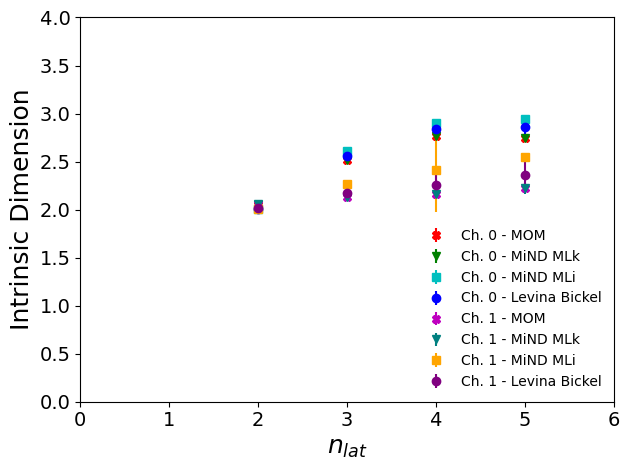

In [87]:
plt.errorbar(nlats,val_ids_ch0[:,1], yerr=val_ids_sdev_ch0[:,1], fmt="o",c='r',marker="X",label="Ch. 0 - MOM")
plt.errorbar(nlats,val_ids_ch0[:,1], yerr=val_ids_sdev_ch0[:,2], fmt="o",c='g',marker="v",label="Ch. 0 - MiND MLk")
plt.errorbar(nlats,val_ids_ch0[:,2], yerr=val_ids_sdev_ch0[:,3], fmt="o",c='c',marker='s',label="Ch. 0 - MiND MLi")
plt.errorbar(nlats,val_ids_ch0[:,0], yerr=val_ids_sdev_ch0[:,0], fmt="o",c='b',label="Ch. 0 - Levina Bickel")
plt.errorbar(nlats,val_ids_ch1[:,1], yerr=val_ids_sdev_ch1[:,1], fmt="o",c='m',marker="X",label="Ch. 1 - MOM")
plt.errorbar(nlats,val_ids_ch1[:,1], yerr=val_ids_sdev_ch1[:,2], fmt="o",c='teal',marker="v",label="Ch. 1 - MiND MLk")
plt.errorbar(nlats,val_ids_ch1[:,2], yerr=val_ids_sdev_ch1[:,3], fmt="o",c='orange',marker='s',label="Ch. 1 - MiND MLi")
plt.errorbar(nlats,val_ids_ch1[:,0], yerr=val_ids_sdev_ch1[:,0], fmt="o",c='purple',label="Ch. 1 - Levina Bickel")
plt.ylabel("Intrinsic Dimension",fontsize=18)
plt.xlabel(r"$n_{lat}$",fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim((0,6))
plt.ylim((0,4))
plt.tight_layout()
plt.legend(frameon=False,loc="lower right")
plt.savefig("ID_calc_comparison.png",dpi=300)